# Homework 2
##### NumPDE

__Devon Kesseli__

Septermber 30th, 2018



#### Problem Statement:
Use a Chebyshev method to solve the second order ordinary differential equation

$$ u''(t) + a u'(t) + b u(t) = f(t) $$

from $t=0$ to $t=1$ with initial conditions $u(0) = 1$ and $u'(0) = 0$.

1. Do a grid convergence study to test the accuracy of your method.
* Setting $f(t)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.

#### Approach:

Given a grid of $t$'s $[t_0,t_1, \cdots , t_n]$, we're looking for the Chebyshev coefficients such that the $t$'s provide a solution to $ u''(t) + a u'(t) + b u(t) = f(t) $.  This will look like:


$$ \underbrace{\begin{bmatrix} 
    0 & 0 & 2 n^2 &4t_{0} n^2 & \dotsb \\
    0 & 0 & 2 n^2 & 4t_{1} n^2 & \dotsb \\
    0 & 0 & 2 n^2 & 4t_{2} n^2  & \dotsb \\
    \vdots & & & \ddots \end{bmatrix}}_{T_n''(t)} \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \end{bmatrix} + a \underbrace{\begin{bmatrix} 
    0 & 2n &2nt_0 & n(4t_0^2 - 2 + \frac{2}{n-2}) & \dotsb \\
    0 & 2n &2nt_1 & n(4t_1^2 - 2 + \frac{2}{n-2}) & \dotsb \\
    0 & 2n &2nt_2 & n(4t_2^2 - 2 + \frac{2}{n-2}) & \dotsb \\
    \vdots & & & \ddots \end{bmatrix}}_{T_n'(t)} \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \end{bmatrix} + b \underbrace{\begin{bmatrix} 
    1 & t_0 & 2t_{0}^2 -1 & \dotsb \\
    1 & t_1 & 2t_{1}^2 -1  & \dotsb \\
    1 & t_2 & 2t_{2}^2 -1  & \dotsb \\
    \vdots & & & \ddots \end{bmatrix}}_{T_n(t)} \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \end{bmatrix}= \begin{bmatrix} f_0 \\ f_1 \\ f_2 \\ \vdots \end{bmatrix}.$$
   
 or, pulling the coefficient vector outside, and using the Chebyshev definition to get the u values back into the correct basis:
 
 $$ \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \end{bmatrix}= \underbrace{\begin{bmatrix} 
    1 & t_0 & 2t_{0}^2 -1 & \dotsb \\
    1 & t_1 & 2t_{1}^2 -1  & \dotsb \\
    1 & t_2 & 2t_{2}^2 -1  & \dotsb \\
    \vdots & & & \ddots \end{bmatrix}^{-1}}_{T_n(t)} \begin{bmatrix} u_0 \\ u_1 \\ u_2 \\ \vdots \end{bmatrix} .$$
 
 I get the left and right hand sides that will be solved.

$$ \big[ \textbf{T}_n''(t) + a \textbf{T}_n'(t)+ b \textbf{T}_n(t) \big] \textbf{T}_n(t)^{-1} \textbf{u}(t) = \textbf{f}(t)$$

After being stuck for a while on how to shift the Chebyshev stable region from $(-1,1)$ to $(0,1)$, I eventually read about how this can be done by setting $x = 2x-1$ do this from the the University of Waterloo http://www.mhtl.uwaterloo.ca/courses/me755/web_chap6.pdf.  I calculated the first few terms of the derivatives to update the vander_chebyshev and chebeval functions from the higher order method notebook. The derivative recursions will stay the applying the chain rule adds an extra factor of 2 to the first derivative, and 4 to the second derivative. $$ \frac{d}{dx}f(2x -1) = f'(x) *\frac{d}{dx}(2x-1) = 2f'(x) $$

In [47]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def shifty_vander_chebyshev(x, n=None): #vander_cheb function from class, shifted to the [0,1] domain
    if n is None:
        n = len(x)
    T = numpy.ones((len(x), n))
    if n > 1:
        T[:,1] = (2*x-1)
    for k in range(2,n):
        T[:,k] = 2 * (2*x-1) * T[:,k-1] - T[:,k-2]
    return T

def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (numpy.cos(numpy.linspace(-numpy.pi, 0, n)))

def shifty_chebeval(z, n=None): #chebeval function from class, shifted to the [0,1] domain
    z = numpy.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = shifty_vander_chebyshev(z, n)
    dTz = numpy.zeros_like(Tz)
    dTz[:,1] = 1
    dTz[:,2] = 8*z - 4
    ddTz = numpy.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,n):
        dTz[:,n]  = n * (2*Tz[:,n-1] + dTz[:,n-2]/(n-2))
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2]/(n-2))
    return [Tz, 2*dTz, 4*ddTz]

In [48]:
def Spring_cheb(n,rhsfunc,a,b): #This function sets up the diff eq. in the problem statement.
    x = cosspace(0, 1, n+1) # n+1 points is n "elements"
    x2 = numpy.insert(x,0,0)
    #x[1]=0
    T = shifty_chebeval(x)
    L = T[2] + a*T[1] + b*T[0]
    rhs = rhsfunc(x)
    L[0] = T[1][0] #Boundary conditions are set at the first 2 points of L
    L[1] = T[0][1]
    rhs[0] = 0
    rhs[1] = 1
    #T[0][1] = T[0][0]
    invT = numpy.linalg.inv(T[0])
    return x, L.dot(invT), rhs

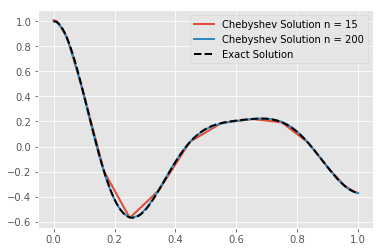

In [49]:
a = 4
b = 200
n = [15,200]

def testfunc(x): #RHS function
    return (42)*numpy.cos(x*10)

def SolFunc(x): #Analytical Solution
    return numpy.exp(-2*x)*((1-21/58)*numpy.cos(14*x))+(21/145)*numpy.sin(10*x)+(21/58)*numpy.cos(10*x)

for i in range(len(n)):
    x, L, rhs = Spring_cheb(n[i], testfunc,a,b)
    uu = numpy.linalg.solve(L, rhs)
    pyplot.plot(x,uu,linewidth=2,label='Chebyshev Solution n = %.0f' % n[i])
f = SolFunc(x)
pyplot.plot(x,f,'k--',label='Exact Solution', linewidth=2)
pyplot.legend(loc='upper right');

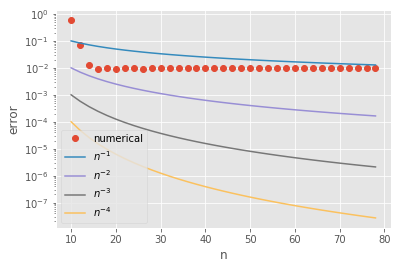

In [66]:
a = 4
b = 200
def testfunc(x):
    return (42)*numpy.cos(x*10)

def mms_error(n, Spring, sol):
    x, L, f = Spring(n, testfunc,a,b)
    u = numpy.linalg.solve(L, f)
    return numpy.linalg.norm(u - sol(x), numpy.inf)

ns = numpy.arange(10,80,2)
errors = [mms_error(n, Spring_cheb, SolFunc) for n in ns]
pyplot.figure()
pyplot.semilogy(ns, errors, 'o', label='numerical')
for p in range(1,5):
    pyplot.semilogy(ns, 1/ns**(p), label='$n^{-%d}$'%p)
pyplot.xlabel('n')
pyplot.ylabel('error')
    
pyplot.legend(loc='lower left');

Unfortunately it looks like I have some source of constant error $(\approx 10^{-2} )$.  I would expect this to give order $h^2$ accuracy The error here is more obvious when comparing the Chebeshev and exact solutions for the $f(t)=0$ case (the Chebeshev plot looks like it's shifted right a pixel).  I think this may be a result of how I set up my boundary conditions (I still haven't figured the best way to set two on one side).  It could also be a missed term in my domain shift, or even an error in the analytic solution I calculated.

## Part 2: Regimes with $f(t)=0$
With $f(t) = 0$, this systems mirrors a non-driven, dampened harmonic oscillator.  There is an "overdamped" (O.D.) regime, where the $a$ term dominates, and the mass (or $u$ value) slowly moves back to equilibrium.  Second is the "underdamped" (U.D.) regime, where $u$ oscillates, with amplitudes decresing inside of an $e^{-bu}$ envelope.  These are seperated by the critical dampening (C.D.) level.

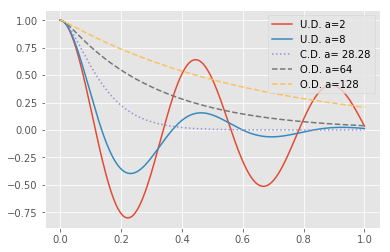

In [52]:
def SolFunc2(x):
    return numpy.exp(-2*x)*(1*numpy.cos(14*x))

b = 200
a = [2,8,2*(b**0.5),64,128]
n = 400
def testfunc(x):
    return x*0

#def testfunc(x):
#    return (4)*numpy.cos(x*10)

for i in range(len(a)):
    x, L, rhs = Spring_cheb(n, testfunc,a[i],b)
    uu = numpy.linalg.solve(L, rhs)
    if a[i] == 2*(b**0.5):
        pyplot.plot(x,uu,':',label='C.D. a= %.2f' % a[i])
    elif a[i] > 2*(b**0.5):
        pyplot.plot(x,uu,'--',label='O.D. a='+str(a[i]))
    else:
        pyplot.plot(x,uu,label='U.D. a='+str(a[i]))
pyplot.legend(loc='upper right');